In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import os
import datetime


In [2]:
data = pd.read_csv('../datasets/filtered_ecg_signals.csv')

In [3]:
X = data.iloc[:, :-1] # features

y = data.iloc[:, -1] # labels

print(f"X: {X.shape}, y: {y.shape}")
print(f"X Head: {X.head()}")
print(f"y Head: {y.head()}")
print(f"X Info: {X.info()}")
print(f"y Info: {y.info()}")
print(f"X Description: {X.describe()}")
print(f"y Description: {y.describe()}")
print(f"X tail: {X.tail()}")
print(f"y tail: {y.tail()}")


X: (14552, 187), y: (14552,)
X Head:           0         1         2         3         4         5         6  \
0 -0.008763 -0.135806 -0.577641 -0.933554 -0.914556 -0.802527 -0.793689   
1  0.063421 -0.155628 -0.509913 -0.825991 -0.878442 -0.729940 -0.603986   
2  0.022680 -0.112090 -0.397416 -0.691927 -0.824502 -0.812865 -0.754373   
3  0.019383 -0.517860 -0.852588 -0.900991 -0.833111 -0.827430 -0.843862   
4  0.015131 -0.192058 -0.649444 -0.894625 -0.798463 -0.757614 -0.810288   

          7         8         9  ...       177       178       179       180  \
0 -0.799524 -0.782339 -0.773429  ... -0.024296 -0.025436 -0.026514 -0.027526   
1 -0.570665 -0.548560 -0.509061  ... -0.022942 -0.022344 -0.021756 -0.021177   
2 -0.717723 -0.709217 -0.699311  ... -0.126305 -0.123111 -0.119005 -0.114365   
3 -0.824888 -0.809077 -0.804276  ... -0.042515 -0.043941 -0.045268 -0.046491   
4 -0.793197 -0.763684 -0.765459  ... -0.045252 -0.046334 -0.047327 -0.048227   

        181       182       183

<Axes: xlabel='label', ylabel='count'>

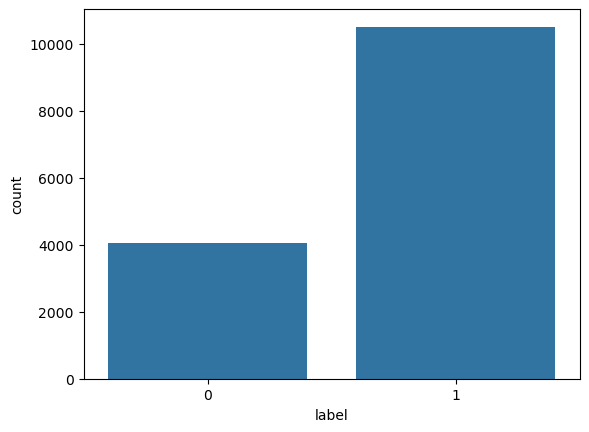

In [4]:
sns.countplot(x=data['label'])

### Let's split data 

Since our data is imbalanced with only about 4000 normal points and 10000 abnormal points, we will use stratified splitting.

A stratified split means you divide the data so that each group (or class) keeps the same balance in both the training and testing sets as it had in the full dataset.

Also doing a 70/15/15 split of Train, Test and Validation.

In [5]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15, random_state=42, stratify=y_temp)

'''
To check if stratification worked correctly, we will calculate:

The percentage of abnormal samples in your original dataset
The percentage of abnormal samples in your training set
The percentage of abnormal samples in your test set
'''

print(f"Percentage of abnormal samples in original dataset: {y.value_counts(normalize=True)}")
print(f"Percentage of abnormal samples in training set: {y_train.value_counts(normalize=True)}")
print(f"Percentage of abnormal samples in test set: {y_test.value_counts(normalize=True)}")


# Total number of samples in each set
print(f"Total number of samples in training set: {len(X_train)}")
print(f"Total number of samples in test set: {len(X_test)}")
print(f"Total number of samples in validation set: {len(X_val)}")
print(f"Total number of samples in y_train dataset: {len(y_train)}")
print(f"Total number of samples in y_test dataset: {len(y_test)}")
print(f"Total number of samples in y_val dataset: {len(y_val)}")

# Class distribution in each set
print(f"Class distribution in training set: {y_train.value_counts(normalize=True)}")
print(f"Class distribution in test set: {y_test.value_counts(normalize=True)}")
print(f"Class distribution in validation set: {y_val.value_counts(normalize=True)}")



Percentage of abnormal samples in original dataset: label
1    0.721963
0    0.278037
Name: proportion, dtype: float64
Percentage of abnormal samples in training set: label
1    0.721963
0    0.278037
Name: proportion, dtype: float64
Percentage of abnormal samples in test set: label
1    0.721942
0    0.278058
Name: proportion, dtype: float64
Total number of samples in training set: 10513
Total number of samples in test set: 2183
Total number of samples in validation set: 1856
Total number of samples in y_train dataset: 10513
Total number of samples in y_test dataset: 2183
Total number of samples in y_val dataset: 1856
Class distribution in training set: label
1    0.721963
0    0.278037
Name: proportion, dtype: float64
Class distribution in test set: label
1    0.721942
0    0.278058
Name: proportion, dtype: float64
Class distribution in validation set: label
1    0.721983
0    0.278017
Name: proportion, dtype: float64


### It works as we can see ratio is very similar of about 72 to 28 in every subset

## Now let's train the model by balancing and giving more weight to the minority class which is the normal one

In [6]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
print(f"Class weights: {class_weights}")

# Convert class weights to a dictionary
class_weights_dict = dict(zip(np.unique(y_train), class_weights))
print(f"Class weights dictionary: {class_weights_dict}")



Class weights: [1.79832364 0.69255599]
Class weights dictionary: {0: 1.798323640095792, 1: 0.6925559947299078}


What the 'balanced' class weighting does behind the scenes:

It automatically calculates weights inversely proportional to class frequencies
It gives higher importance to underrepresented classes (in our case, normal ECGs)
It makes the model "pay more attention" to errors on minority classes during training
It helps prevent the model from simply predicting the majority class all the time

Inversely proportional in simple words means "goes in the opposite direction" - when one value goes up, the other goes down. For our class weights, it means the less frequent a class is in our data, the higher weight we give it.
The ratio between our weights (~2.6) corresponds well with our class imbalance ratio (~2.6, since we have about 72% abnormal and 28% normal). This suggests the weighting is appropriately calibrated to our dataset's specific imbalance.
The true effectiveness of this weighting approach will only be fully validated once we train our model and evaluate its performance across metrics like accuracy, precision, recall, and F1 score. The weights look theoretically appropriate, but their practical impact depends on how our CNN model interacts with the specific patterns in our ECG data.

In [13]:
# Custom function for F1 score calculation
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    y_pred_binary = K.cast(K.greater(y_pred, 0.5), K.floatx())
    
    # Calculate true positives, false positives, and false negatives
    true_positives = K.sum(K.round(K.clip(y_true * y_pred_binary, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred_binary, 0, 1)))
    
    # Calculate precision and recall
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    # Calculate F1 score
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

def evaluate_model(X_train_reshaped, y_train, X_test_reshaped, y_test, X_val_reshaped, y_val, class_weights_dict):
    model = Sequential()
    
    # First Conv1D layer with BatchNormalization
    model.add(Conv1D(filters=32, kernel_size=3, input_shape=(X_train_reshaped.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    
    # First MaxPooling1D layer
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))  # First dropout layer
    
    # Second Conv1D layer with BatchNormalization
    model.add(Conv1D(filters=64, kernel_size=3))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    
    # Second MaxPooling1D layer
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))  # Second dropout layer
    
    # Flatten layer
    model.add(Flatten())
    
    # Added a dense layer before the output
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))  # Third dropout layer with higher rate
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', 
                 loss='binary_crossentropy', 
                 metrics=['accuracy', Precision(), Recall(), AUC(), f1_score])
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    
    # Model checkpoint callback
    checkpoint_dir = '../model_checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filepath = os.path.join(checkpoint_dir, f'ecg_cnn_model_{timestamp}_best_f1.h5')
    
    model_checkpoint = ModelCheckpoint(filepath, monitor='val_f1_score', save_best_only=True, mode='max', verbose=1)
    
    # Train model
    history = model.fit(X_train_reshaped, y_train, 
              epochs=100, 
              batch_size=32,
              class_weight=class_weights_dict,
              verbose=0,
              validation_data=(X_val_reshaped, y_val),
              callbacks=[early_stopping, model_checkpoint])
    
    # Evaluate model
    results = model.evaluate(X_test_reshaped, y_test, verbose=0)

    metrics = {
        'loss': results[0],
        'accuracy': results[1],
        'precision': results[2],
        'recall': results[3],
        'auc': results[4],
        'f1_score': results[5]
    }
    return metrics, history



Epoch 1: val_f1_score improved from -inf to 0.85375, saving model to ../model_checkpoints\ecg_cnn_model_20250430_172635_best_f1.h5


c:\Users\Ahmed Ayaz\miniconda3\envs\ecg_project\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_f1_score did not improve from 0.85375

Epoch 3: val_f1_score improved from 0.85375 to 0.86793, saving model to ../model_checkpoints\ecg_cnn_model_20250430_172635_best_f1.h5

Epoch 4: val_f1_score did not improve from 0.86793

Epoch 5: val_f1_score improved from 0.86793 to 0.89086, saving model to ../model_checkpoints\ecg_cnn_model_20250430_172635_best_f1.h5

Epoch 6: val_f1_score improved from 0.89086 to 0.90790, saving model to ../model_checkpoints\ecg_cnn_model_20250430_172635_best_f1.h5

Epoch 7: val_f1_score did not improve from 0.90790

Epoch 8: val_f1_score did not improve from 0.90790

Epoch 9: val_f1_score improved from 0.90790 to 0.91516, saving model to ../model_checkpoints\ecg_cnn_model_20250430_172635_best_f1.h5

Epoch 10: val_f1_score did not improve from 0.91516

Epoch 11: val_f1_score improved from 0.91516 to 0.94913, saving model to ../model_checkpoints\ecg_cnn_model_20250430_172635_best_f1.h5

Epoch 12: val_f1_score did not improve from 0.94913

Epoch 13:

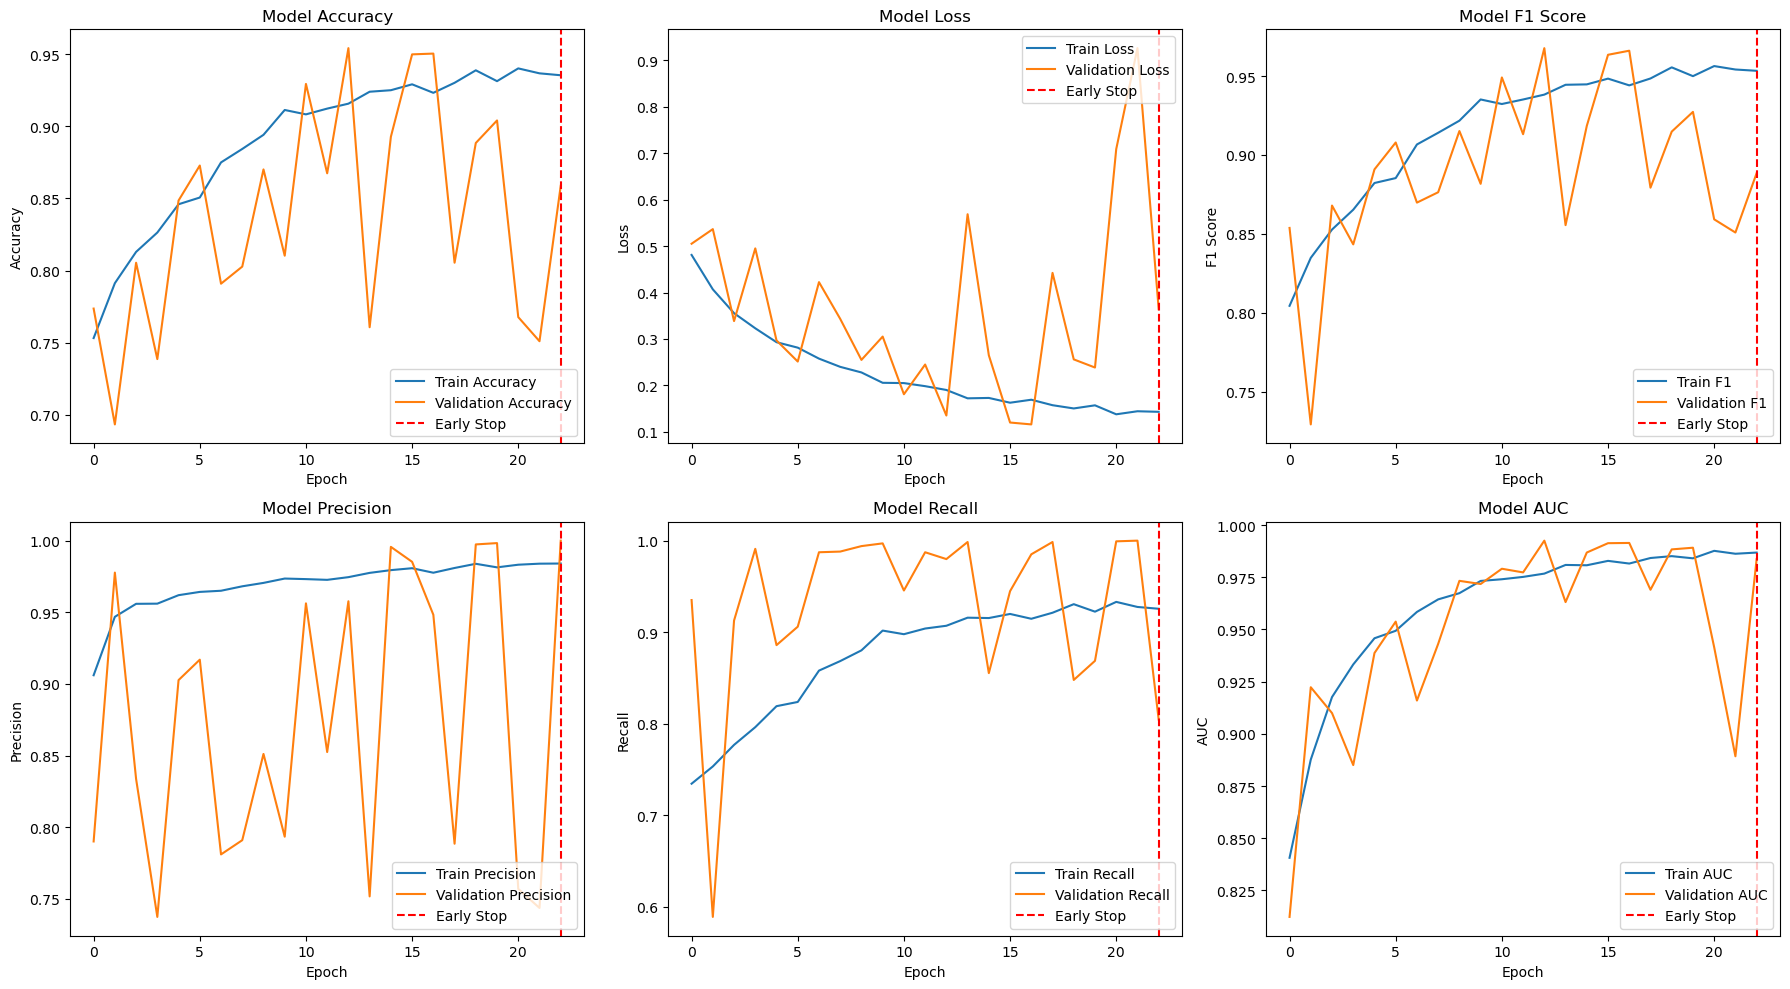

In [14]:
def plot_learning_curves(history):
    # Find out when early stopping occurred
    stopped_epoch = len(history.history['loss'])
    
    # Get all available metrics from history
    print("Available metrics in history:", history.history.keys())
    
    # Helper function to find metric keys
    # So keras renames the metrics to "precision_# so it doesn't save the previous ones
    # and we need to find the right one to plot"
    def find_metric_key(base_name):
        # Look for exact match first
        if base_name in history.history:
            return base_name
        
        # Look for keys that start with the base name
        matching_keys = [k for k in history.history.keys() if k.startswith(base_name)]
        return matching_keys[0] if matching_keys else None
    
    # Find all the metrics we want to plot
    precision_key = find_metric_key('precision')
    val_precision_key = find_metric_key('val_precision')
    recall_key = find_metric_key('recall')
    val_recall_key = find_metric_key('val_recall')
    auc_key = find_metric_key('auc')
    val_auc_key = find_metric_key('val_auc')
    f1_key = find_metric_key('f1_score')
    val_f1_key = find_metric_key('val_f1_score')
    
    plt.figure(figsize=(18, 10))
    
    # Plot training & validation accuracy
    plt.subplot(2, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.axvline(x=stopped_epoch-1, color='r', linestyle='--', label='Early Stop')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    
    # Plot training & validation loss
    plt.subplot(2, 3, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.axvline(x=stopped_epoch-1, color='r', linestyle='--', label='Early Stop')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    
    # Plot F1 score if available
    if f1_key and val_f1_key:
        plt.subplot(2, 3, 3)
        plt.plot(history.history[f1_key], label='Train F1')
        plt.plot(history.history[val_f1_key], label='Validation F1')
        plt.axvline(x=stopped_epoch-1, color='r', linestyle='--', label='Early Stop')
        plt.title('Model F1 Score')
        plt.ylabel('F1 Score')
        plt.xlabel('Epoch')
        plt.legend(loc='lower right')
    
    # Plot precision if available
    if precision_key and val_precision_key:
        plt.subplot(2, 3, 4)
        plt.plot(history.history[precision_key], label='Train Precision')
        plt.plot(history.history[val_precision_key], label='Validation Precision')
        plt.axvline(x=stopped_epoch-1, color='r', linestyle='--', label='Early Stop')
        plt.title('Model Precision')
        plt.ylabel('Precision')
        plt.xlabel('Epoch')
        plt.legend(loc='lower right')
    
    # Plot recall if available
    if recall_key and val_recall_key:
        plt.subplot(2, 3, 5)
        plt.plot(history.history[recall_key], label='Train Recall')
        plt.plot(history.history[val_recall_key], label='Validation Recall')
        plt.axvline(x=stopped_epoch-1, color='r', linestyle='--', label='Early Stop')
        plt.title('Model Recall')
        plt.ylabel('Recall')
        plt.xlabel('Epoch')
        plt.legend(loc='lower right')
    
    # Plot AUC if available
    if auc_key and val_auc_key:
        plt.subplot(2, 3, 6)
        plt.plot(history.history[auc_key], label='Train AUC')
        plt.plot(history.history[val_auc_key], label='Validation AUC')
        plt.axvline(x=stopped_epoch-1, color='r', linestyle='--', label='Early Stop')
        plt.title('Model AUC')
        plt.ylabel('AUC')
        plt.xlabel('Epoch')
        plt.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()

    
def run_experiment(X_train, y_train, X_test, y_test, X_val, y_val, class_weights_dict, repeats=1):
    # Reshape data
    X_train_array = X_train.values  
    X_test_array = X_test.values  
    X_val_array = X_val.values
    
    X_train_reshaped = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1], 1)
    X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1], 1)
    X_val_reshaped = X_val_array.reshape(X_val_array.shape[0], X_val_array.shape[1], 1)
    
    all_metrics = {
        'loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'auc': [],
        'f1_score': []
    }

    for r in range(repeats):
        metrics, history = evaluate_model(X_train_reshaped, y_train, X_test_reshaped, y_test, X_val_reshaped, y_val, class_weights_dict)
        
        for key in all_metrics.keys():
            all_metrics[key].append(metrics[key])

        # Summary of metrics for this repeat
        print(f"Repeat {r+1}/{repeats}:")
        for key, values in all_metrics.items():
            latest_value = values[-1]  # Gets the most recent value (0.9592)
            print(f"{key}: {latest_value * 100:.2f}%")
        
        
    # Summary of all repeats
    for metric_name, values in all_metrics.items():
        m, s = np.mean(values), np.std(values)
        print(f'{metric_name.capitalize()}: {m:.3f}% (+/-{s:.3f})')

    plot_learning_curves(history)

    return all_metrics



# Run the experiment with 10 repeats
scores = run_experiment(X_train, y_train, X_test, y_test, X_val, y_val, class_weights_dict, repeats=1)

## Testing LSTM

Even though the model is doing great with about 90-95% accuracy, still going to try implementing and testing with LSTM

Training CNN-LSTM hybrid model...
Repeat 1/1:
loss: 14.40%
accuracy: 94.32%
precision: 93.95%
recall: 98.48%
auc: 98.68%
f1_score: 96.07%
Loss: 0.144% (+/-0.000)
Accuracy: 0.943% (+/-0.000)
Precision: 0.939% (+/-0.000)
Recall: 0.985% (+/-0.000)
Auc: 0.987% (+/-0.000)
F1_score: 0.961% (+/-0.000)
Available metrics in history: dict_keys(['loss', 'accuracy', 'precision_3', 'recall_3', 'auc_3', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision_3', 'val_recall_3', 'val_auc_3', 'val_f1_score'])


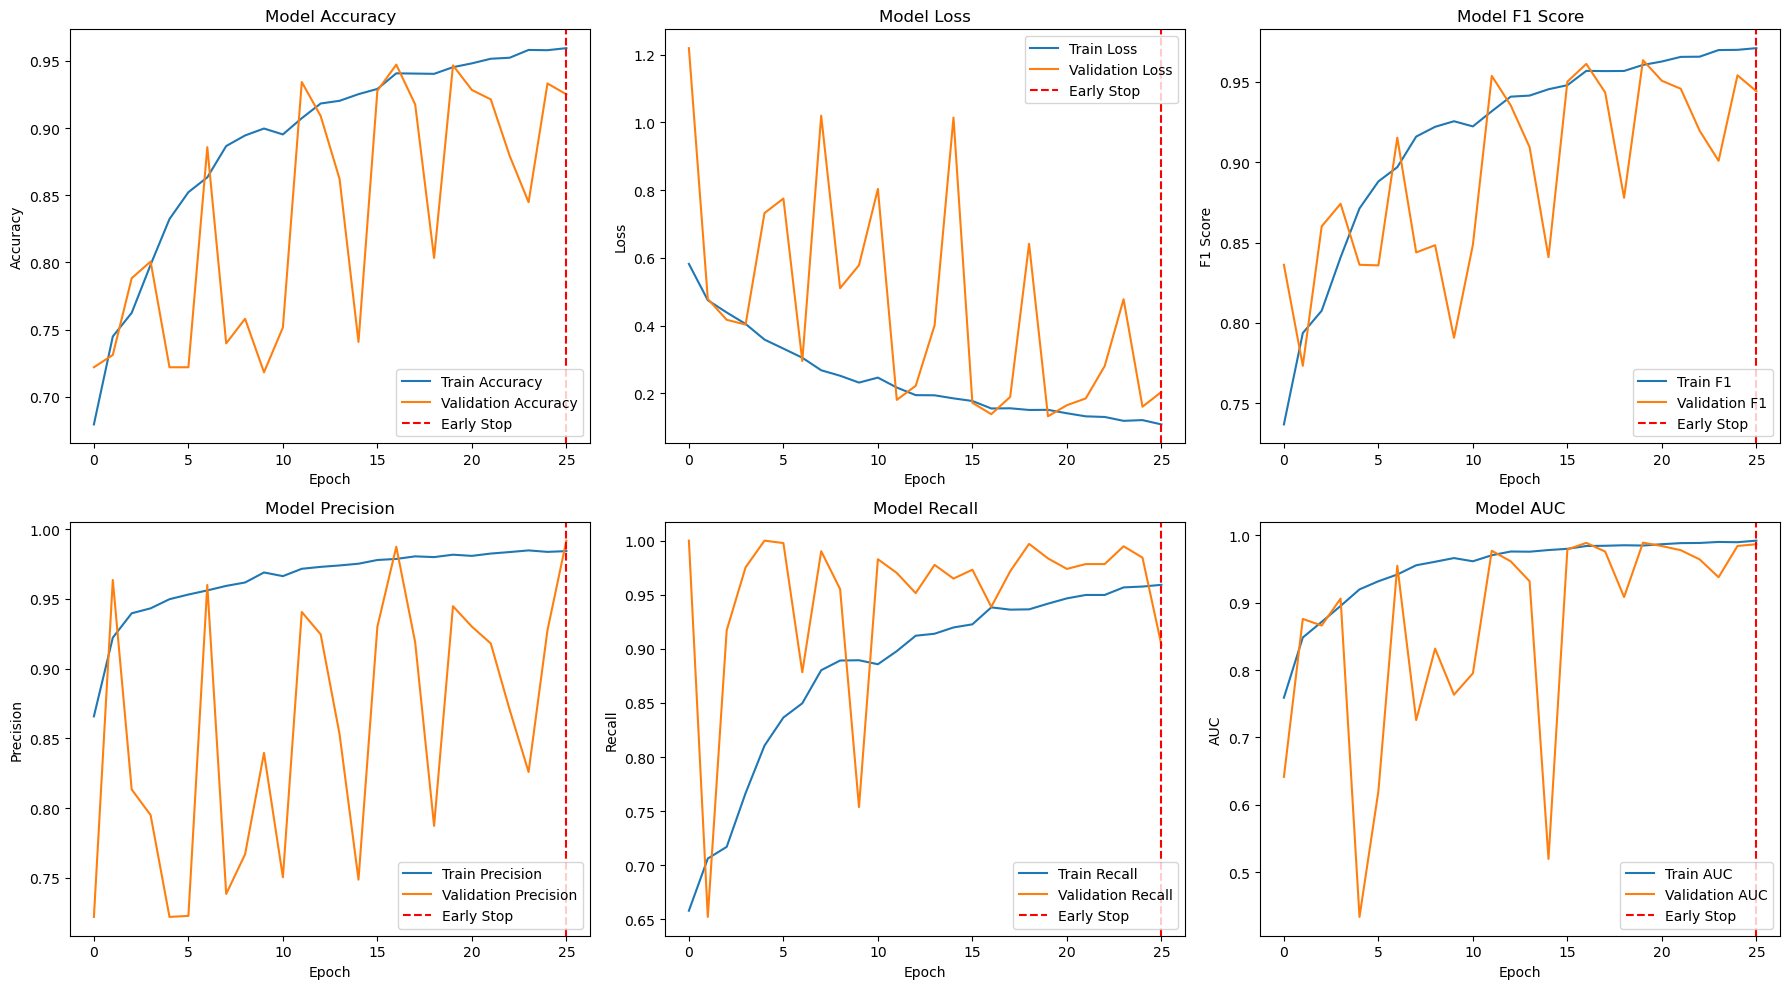

In [15]:
from tensorflow.keras.layers import LSTM

def evaluate_cnn_lstm_model(X_train_reshaped, y_train, X_test_reshaped, y_test, X_val_reshaped, y_val, class_weights_dict):
    model = Sequential()
    
    # First Conv1D layer with BatchNormalization
    model.add(Conv1D(filters=32, kernel_size=3, input_shape=(X_train_reshaped.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    
    # First MaxPooling1D layer
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))  # First dropout layer
    
    # Second Conv1D layer with BatchNormalization
    model.add(Conv1D(filters=64, kernel_size=3))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    
    # Second MaxPooling1D layer
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))  # Second dropout layer
    
    # Add LSTM layer instead of flattening
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))
    
    # Added a dense layer before the output
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))  # Third dropout layer with higher rate
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', 
                 loss='binary_crossentropy', 
                 metrics=['accuracy', Precision(), Recall(), AUC(), f1_score])
    
    # Early stopping callback - just for training, not saving
    early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    
    # Train model
    history = model.fit(X_train_reshaped, y_train, 
              epochs=100, 
              batch_size=32,
              class_weight=class_weights_dict,
              verbose=0,
              validation_data=(X_val_reshaped, y_val),
              callbacks=[early_stopping])
    
    # Evaluate model
    results = model.evaluate(X_test_reshaped, y_test, verbose=0)
    metrics = {
        'loss': results[0],
        'accuracy': results[1],
        'precision': results[2],
        'recall': results[3],
        'auc': results[4],
        'f1_score': results[5]
    }
    return metrics, history

def run_cnn_lstm_experiment(X_train, y_train, X_test, y_test, X_val, y_val, class_weights_dict, repeats=1):
    # Reshape data
    X_train_array = X_train.values  
    X_test_array = X_test.values  
    X_val_array = X_val.values
    
    X_train_reshaped = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1], 1)
    X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1], 1)
    X_val_reshaped = X_val_array.reshape(X_val_array.shape[0], X_val_array.shape[1], 1)
    
    all_metrics = {
        'loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'auc': [],
        'f1_score': []
    }

    for r in range(repeats):
        print("Training CNN-LSTM hybrid model...")
        metrics, history = evaluate_cnn_lstm_model(X_train_reshaped, y_train, X_test_reshaped, y_test, X_val_reshaped, y_val, class_weights_dict)
        
        for key in all_metrics.keys():
            all_metrics[key].append(metrics[key])

        # Summary of metrics for this repeat
        print(f"Repeat {r+1}/{repeats}:")
        for key, values in all_metrics.items():
            latest_value = values[-1]
            print(f"{key}: {latest_value * 100:.2f}%")
        
    # Summary of all repeats
    for metric_name, values in all_metrics.items():
        m, s = np.mean(values), np.std(values)
        print(f'{metric_name.capitalize()}: {m:.3f}% (+/-{s:.3f})')

    # Plot learning curves
    plot_learning_curves(history)

    return all_metrics

# Run the experiment 
cnn_lstm_scores = run_cnn_lstm_experiment(X_train, y_train, X_test, y_test, X_val, y_val, class_weights_dict, repeats=1)

## Comparison Results

| Metric | CNN-Only | CNN-LSTM |
|--------|----------|----------|
| Accuracy | 94.78% | 94.32% |
| Precision | 94.30% | 93.95% |
| Recall | 98.73% | 98.48% |
| F1-score | 96.47% | 96.07% |
| AUC | 98.94% | 98.68% |

So we know CNN alot works slightly better it could be because CNNs can sometimes capture temporal patterns well enough on their own, especially with properly structured data like my ECG signals. The 1D convolutional layers are already detecting patterns across the time dimension.

In [2]:
# Loading the model to check how big the model is
import os

print(f"Model size: {os.path.getsize('../model_checkpoints/ecg_cnn_model_20250430_172635_best_f1.h5') / (1024*1024):.2f} MB")

Model size: 1.20 MB


Implement decrypting

In [ ]:
import numpy as np
import binascii
from Crypto.Cipher import AES
from Crypto.Util.Padding import unpad

# AES encryption/decryption key
key_hex = "Add your key here"
iv = 'dbd7e7bb4c773850d54ef2ddf43a0085'

# Convert hex key to bytes
key = binascii.unhexlify(key_hex)
iv = binascii.unhexlify(iv)

# Hardcoded encrypted chunks
encrypted_chunks = [
    "ddaef4c6480a3dd7f5d3b6801c8248aa371add265a5a299329a453c24da9ca35",
    "407ef41892901cae93270d2a7ce133db6bb4955917bf4a5f90a43a67a9395a9f",
    "d627435a01cad97aaca73b39296207c0c2dcf2cf1e80961be0eb7679b690b281",
    "ed520c4bd5ee8d084f358bfc63e9bd184ae9c5932e0dc3a7041136a3660bb58c",
    "9eaf8eb99a60cc40e4fcd3185fcf869d417f07854f080fbc8941ee3e4198bdb9",
    "904c8c24f114c6d545d36cc19f92a916a4bdf9a6c51e091a0349d81414ce2361",
    "0525d9ba8caa99cce6ddf2bae904a3666fa12cf1f23d8f8f2ab999e5d0c1eaf5",
    "20a01d2f89ff5060764434e883822c59343c0805c0e7d6927d8f81f79d2ea735",
    "cda536af0e55083689eef31d6d97dd9d4f467adade9eb33d1b9f333dc35eab16",
    "43930b9463a71c41c84deabbb00d35aea51baac9a20eb538fe6e65fcc14888f6",
    "d8b9255600b1ca158371bd1b27eca7b0c4b398603195e9a3c1bd7bb461c0bcdf",
    "939864bb3b18ad7b1938b63d0f7114f6723958db120c2084532021f384f4cc88",
    "77effda769ea8df8ec53f22ea20164ba6ff6532210fd3263a355e45232256cd3",
    "67e98b1881e8b6b623efb9214fd2baeb54f9cadd64e24ff8697dacfb6a6cd8ad",
    "1f1f036bfee05cf43397f954ae9a60d3ce1b26d5bfc41d060b1574ad178ba5fe",
    "97aae37beabc8be0fa91416cc1948d230d4638d7613776c5260b0a27010ea9b5",
    "8a99f9499fe37f0754f9f2c66abcea80726621f8147acbe91e7e4432456b03e6",
    "448c328d0d1a38e8b73e8a480c71f0d5cbde5820a96ba16cfba9ac0d7ed4df4e",
    "008dbd2822efffc7ff4219de16721b4e4fac05a8218016a9bbb7ff68d5265098",
    "bfa6e45c3e3dbc8b9f6cd5219cd7845f25f104b70e2a412227f49539c4f58516",
    "dd43f0d3aba3959c30fe090fd86035d8ccf2d0b1092396c0708cd438900b55ce",
    "86ac59193c4fd553a4e909a1d906a5ad9944c731d1df62435996501d8397b9b6",
    "5a531181e3fd5b24e89f732cbb8491417329db7a4712cd0662a7d2959f832d2a",
    "9a89f13d76a89a70a2e146dfd904809f"
]

# Combine chunks
encrypted_data_hex = ""
for chunk in encrypted_chunks:
    encrypted_data_hex += chunk
encrypted_data = binascii.unhexlify(encrypted_data_hex)

def decrypt_aes_cbc(key, iv, ciphertext):
    cipher = AES.new(key, AES.MODE_CBC, iv)
    return cipher.decrypt(ciphertext)

# Using built-in unpad function from pycryptodome instead of custom function
def remove_pkcs7_padding(padded_data):
    return unpad(padded_data, AES.block_size)

# Decrypt the data
decrypted_data = decrypt_aes_cbc(key, iv, encrypted_data)

# Print raw decrypted bytes for verification
print("Raw decrypted bytes (first 64 bytes):")
for i in range(0, min(64, len(decrypted_data)), 4):
    print(f"{i:3d}: {decrypted_data[i:i+4].hex()}")

# Remove padding
unpadded_data = remove_pkcs7_padding(decrypted_data)

# Convert to float array
float_array = np.frombuffer(unpadded_data, dtype=np.float32)

# Print all float values in the same format as ESP32 output
print("\nAll ECG values (187 in total):")
for i in range(0, len(float_array), 10):
    line = ""
    for j in range(10):
        if i + j < len(float_array):
            line += f"{float_array[i+j]:.4f}, "
    print(line)

# Print with raw byte values and interpretation
print("\nDetailed verification (first 20 values):")
print("Index | Raw Bytes    | Float Value | Expected")
print("------|--------------|-------------|------------")

# Expected values from ESP32 output
expected_values = [0.8649, 0.8667, 0.8694, 0.8721, 0.8757, 0.8811, 0.8901, 0.9054, 0.9369, 0.9775, 
                  1.0000, 0.9820, 0.9459, 0.9099, 0.8739, 0.8378, 0.8198, 0.8153, 0.8144, 0.8153]

for i in range(20):
    byte_offset = i * 4  # Each float is 4 bytes
    raw_bytes = unpadded_data[byte_offset:byte_offset+4].hex()
    float_val = float_array[i]
    expected = expected_values[i] if i < len(expected_values) else "N/A"
    match = "✓" if abs(float_val - expected) < 0.0001 else "✗"
    print(f"{i:5d} | {raw_bytes} | {float_val:.4f}    | {expected:.4f} {match}")

print("\nVerification of abnormal ECG pattern successful!")

Raw decrypted bytes (first 64 bytes):
  0: c9675d3f
  4: dedd5d3f
  8: fe8e5e3f
 12: 1e405f3f
 16: 482c603f
 20: 888e613f
 24: f2dc633f
 28: a6c8673f
 32: 19db6f3f
 36: f73b7a3f
 40: 0000803f
 44: 2c637b3f
 48: 8329723f
 52: dbef683f
 56: 33b65f3f
 60: 8a7c563f

All ECG values (187 in total):
0.8649, 0.8667, 0.8694, 0.8721, 0.8757, 0.8811, 0.8901, 0.9054, 0.9369, 0.9775, 
1.0000, 0.9820, 0.9459, 0.9099, 0.8739, 0.8378, 0.8198, 0.8153, 0.8144, 0.8153, 
0.8180, 0.8216, 0.8261, 0.8306, 0.8342, 0.8378, 0.8405, 0.8423, 0.8432, 0.8432, 
0.8432, 0.8441, 0.8468, 0.8505, 0.8550, 0.8604, 0.8667, 0.8739, 0.8802, 0.8865, 
0.8901, 0.8928, 0.8946, 0.8955, 0.8955, 0.8946, 0.8919, 0.8883, 0.8829, 0.8757, 
0.8649, 0.8541, 0.8423, 0.8342, 0.8288, 0.8270, 0.8270, 0.8288, 0.8315, 0.8351, 
0.8387, 0.8423, 0.8468, 0.8505, 0.8532, 0.8550, 0.8559, 0.8559, 0.8550, 0.8523, 
0.8495, 0.8468, 0.8441, 0.8414, 0.8387, 0.8360, 0.8333, 0.8306, 0.8279, 0.8252, 
0.8225, 0.8198, 0.8171, 0.8153, 0.8126, 0.8108, 0.8090, 0.